**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import glob
import time
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

%matplotlib inline

### Load data

length of car images: 8792 ; length of noncar images: 8968


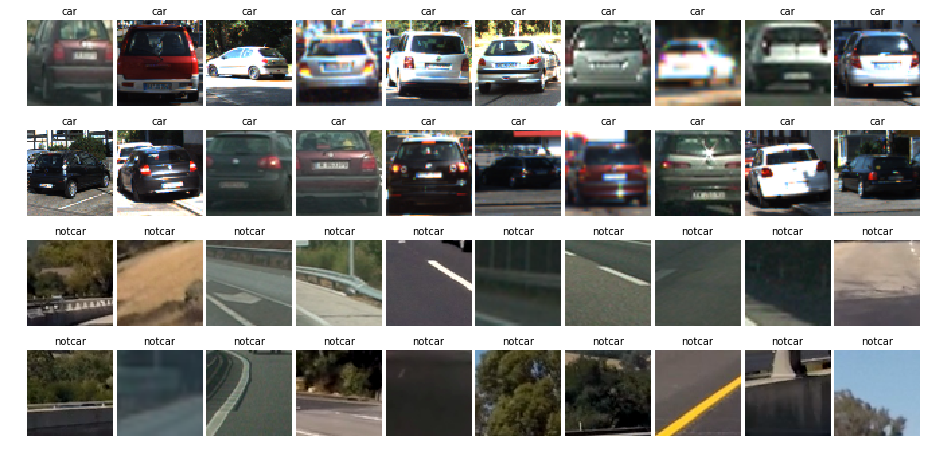

In [2]:
# Load training images 
cars = glob.glob('training_data/vehicles/**/*.png')
notcars = glob.glob('training_data/non-vehicles/**/*.png')
print('length of car images:', len(cars), ';', 'length of noncar images:', len(notcars))


# Visualization of random car and noncar images
fig, axs = plt.subplots(4, 10, figsize=(16, 8))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
axs = axs.ravel()


for i in range(20):
    img = mpimg.imread(cars[np.random.randint(0, len(cars))])
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in range(20, 40):
    img = mpimg.imread(notcars[np.random.randint(0, len(notcars))])
    axs[i].axis('off')
    axs[i].set_title('notcar', fontsize=10)
    axs[i].imshow(img)

### Color and HOG classify

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
    return features

### HOG features extraction


In [4]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

The visualise=True flag tells the function to output a visualization of the HOG feature computation. Here we will take a look at a single color channel for a random car image, and its corresponding HOG visulization.

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Hog feature shape: (7, 7, 2, 2, 9)


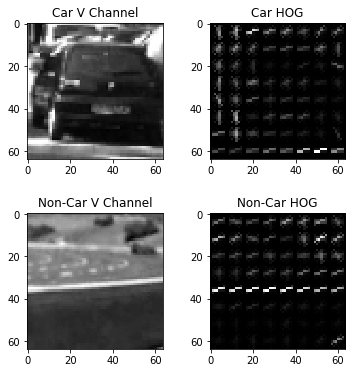

In [5]:
# Plot an example of hog features
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_img = mpimg.imread(cars[car_ind])
car_hsv = cv2.cvtColor(car_img, cv2.COLOR_RGB2HSV)
car_feature, car_hog = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
notcar_img = mpimg.imread(notcars[notcar_ind])
notcar_hsv = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2HSV)
notcar_feature, notcar_hog = get_hog_features(notcar_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

print('Hog feature shape:', car_feature.shape)

# Visualization 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,6))
f.subplots_adjust(hspace=.4, wspace=.2)
ax1.imshow(car_img[:,:,2], cmap='gray')
ax1.set_title('Car V Channel', fontsize=12)
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG', fontsize=12)
ax3.imshow(notcar_img[:,:,2], cmap='gray')
ax3.set_title('Non-Car V Channel', fontsize=12)
ax4.imshow(notcar_hog, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=12)

### Train the classifier using selected HOG features and color features

Feature Extraction:
* Spatial Features
* Color Histogram Features
* HOG Features

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial(), color_hist() and get_hog_features()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            # Apply bin_spatial()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors

    return features

In [7]:
# Tweak these parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 650] # Min and max in y to search in slide_window()

# Shuffle the training images
cars = shuffle(cars)
notcars = shuffle(notcars)

# Extract features of cars and notcars
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


89.28 Seconds to extract HOG features...


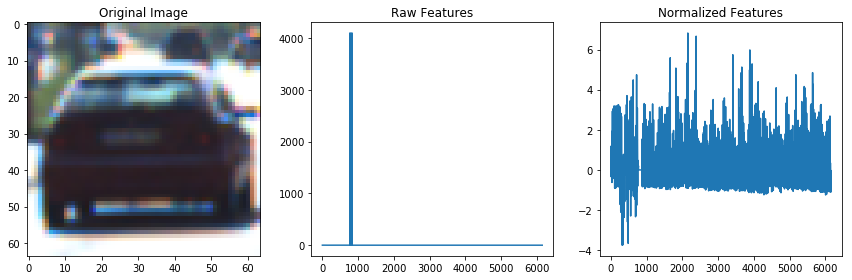

In [8]:
# Plot an example of raw and scaled features
car_ind = np.random.randint(0, len(cars))

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image', fontsize=12)
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features', fontsize=12)
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features', fontsize=12)
fig.tight_layout()

### Train a Classifier

Here a Linear SVC is used.

In [9]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()

svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Save data to pickle file
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )

print('Classifier parameters were saved to file')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
4.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9876
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.001 Seconds to predict 10 labels with SVC
Classifier parameters were saved to file


SVM training approach:

'''

| No. | color space | orient | pix per cell | cell per clock | hog channel | spatial size | hist bins | spatial feat | hist feat | hog feat | extract time | test accuracy | traing time |
|:---:|:-----------:|:------:|:------------:|:--------------:|:-----------:|:------------:|:---------:|:------------:|:---------:|:--------:|:-------------:|:-----------:|:-------------|
| #1 | HSV   | 9 | 8 | 2 | 2  | (32, 32) | 32 | False | False | True | 37.41s  | 94.82% | 11.31s|
| #2 | HSV   | 9 | 8 | 2 | ALL| (32, 32) | 32 | False | False | True | 95.08s  | 97.97% | 21.67s|
| #3 | HSV   | 9 | 8 | 2 | 2  | (32, 32) | 32 | True  | True  | True | 108.73s | 97.92% | 20.21s|
| #4 | HSV   | 9 | 8 | 2 | ALL| (32, 32) | 32 | True  | True  | True | 111.76s | 98.99% | 34.33s|
| #5 | HSV   | 9 | 8 | 2 | ALL| (16, 16) | 32 | True  | True  | True | 87.686s | 98.82% | 21.85s|
| #6 | YUV   | 9 | 8 | 2 | 0  | (32, 32) | 32 | False | False | True | 46.96s  | 94.93% | 10.95s|
| #7 | YUV   | 9 | 8 | 2 | ALL| (32, 32) | 32 | False | False | True | 98.08s  | 97.96% | 21.69s|
| #8 | YUV   | 9 | 8 | 2 | ALL| (32, 32) | 32 | True  | True  | True | 141.25s | 98.86% | 33.62s|
| #9 | YCrCb | 9 | 8 | 2 | 0  | (32, 32) | 32 | False | False | True | 33.77s  | 94.82% | 9.94s |
| #10| YCrCb | 9 | 8 | 2 | ALL| (32, 32) | 32 | False | False | True | 97.41s  | 97.97% | 21.67s|
| #11| YCrCb | 9 | 8 | 2 | ALL| (32, 32) | 32 | True  | True  | True | 126.75s | 98.85% | 32.79s|
| #12| YCrCb | 9 | 8 | 2 | ALL| (16, 16) | 32 | True  | True  | True | 135.49s | 98.76% | 20.17s|

'''

In [10]:
# Load data from pickle file
print('Loading Classifier parameters...')
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
print('Loading is done')

Loading Classifier parameters...
Loading is done


### Method for Using Classifier to Detect Cars in an Image

In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bboxs_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))   
            #test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxs_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bboxs_list

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


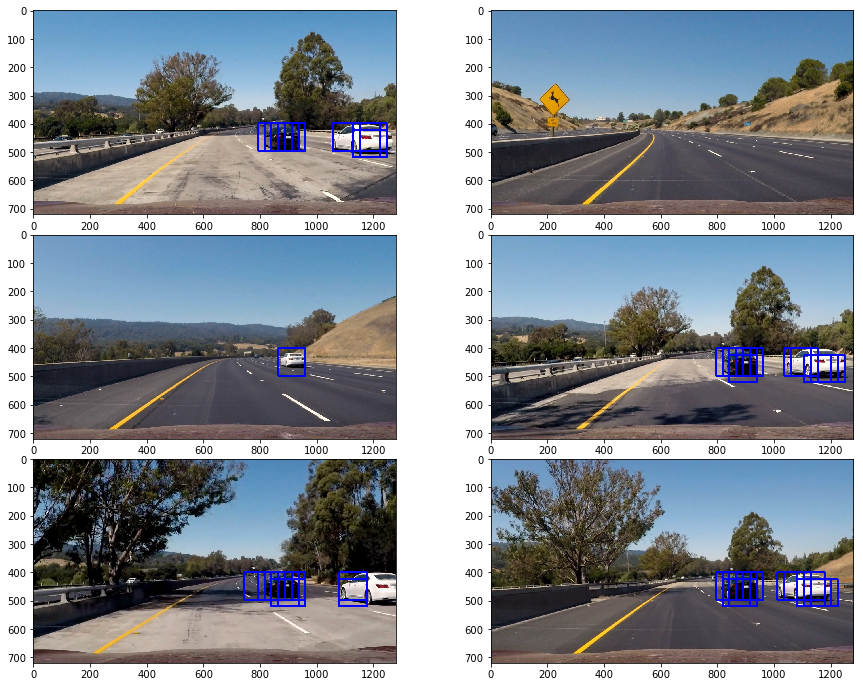

In [12]:
ystart = y_start_stop[0]
ystop = y_start_stop[1]
scale = 1.5

test_images = glob.glob('test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,12))
fig.subplots_adjust(hspace = .1, wspace=.05)
axs = axs.ravel()

for i, img in enumerate(test_images):
    img = mpimg.imread(img)
    out_img, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    axs[i].imshow(out_img)

### Heatmap Detection

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image

    return img

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


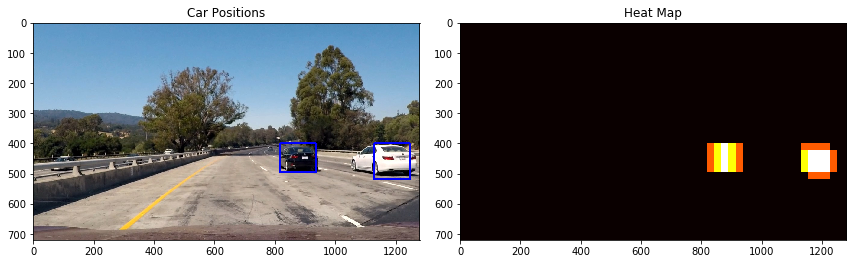

In [14]:
# Read in image similar to one shown above 
image = mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, hist_bins)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

### Vehicle Detection Pipeline

In [15]:
def detection_pipeline(img):
    out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                  cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


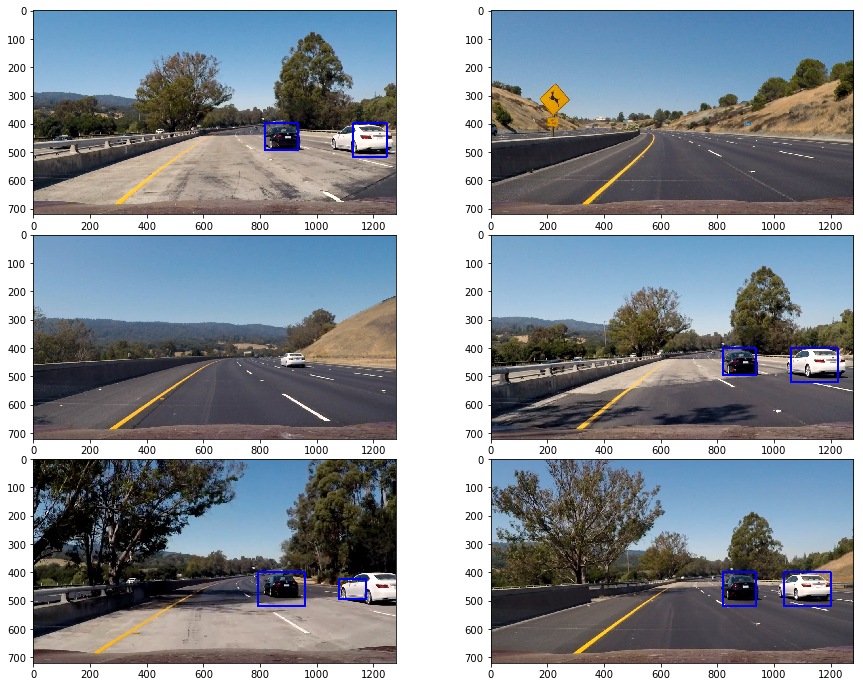

In [16]:
# Run pipeline for all the test images
test_images = glob.glob('test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,12))
fig.subplots_adjust(hspace = .1, wspace=.05)
axs = axs.ravel()

for i, img in enumerate(test_images):
    img = mpimg.imread(img)
    out_img = detection_pipeline(img)
    axs[i].imshow(out_img)
    mpimg.imsave('output_images/result' + str(i+1) + '.jpg', out_img)

### Video Pipeline

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

This only processes a frame at a time without accounting for information from previous frames.

In [18]:
video_output = 'test_video_result.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(detection_pipeline)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:14<00:00,  2.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

Wall time: 15.5 s


#### Define a Class to Store Data from Vehicle Detections.

In [19]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of boxs in previous n frames
        self.prev_boxs = [] 
        
    def add_boxs(self, boxs):
        self.prev_boxs.append(boxs)
        if len(self.prev_boxs) > 10:
            # throw out oldest rectangle set(s)
            self.prev_boxs = self.prev_boxs[len(self.prev_boxs)-10:]

In [20]:
det = Vehicle_Detect()

def detection_pipeline_video(img):
    out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                  cell_per_block, spatial_size, hist_bins)
    
    # add detections to the history
    if len(box_list) > 0:
        det.add_boxs(box_list)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    for box_list in det.prev_boxs:
        heat = add_heat(heat, box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1 + len(det.prev_boxs)//2)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [21]:
video_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(detection_pipeline_video)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:31<00:00,  2.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 7min 31s
